<a href="https://colab.research.google.com/github/DyanielCX/DLI-Assm/blob/main/GUOXI_Supervised_Tree_Based_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import All Dependencies & Libraries

In [105]:
# =========================
# Setup
# =========================
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, RocCurveDisplay
)

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC

# Reproducibility
np.random.seed(42)


## Load and Preprocess Dataset

In [106]:
# =========================
# Data Loading
# =========================
# (Using the same dataset your team used on GitHub — unchanged)
DATA_URL = "https://raw.githubusercontent.com/DyanielCX/DLI-Assm/refs/heads/main/dataset_B_05_2020_1.csv"

df = pd.read_csv(DATA_URL)
df["url"] = df["url"].str.lower()

print("Shape:", df.shape)
df.head(3)

# =========================
# Pre-processing (NO leakage)
# =========================
y = df["status"].values
ml_features = df.drop(columns=["url", "status"])

# Split FIRST, then scale using TRAIN ONLY
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    ml_features, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler().fit(X_train_raw)
X_train_ml = scaler.transform(X_train_raw)
X_test_ml  = scaler.transform(X_test_raw)

print("X_train_ml:", X_train_ml.shape, "| X_test_ml:", X_test_ml.shape)



Shape: (11430, 89)
X_train_ml: (9144, 87) | X_test_ml: (2286, 87)


# Train and Evaluate Tree-Based


In [107]:
# =========================
# Train Supervised Tree-Based Models
# =========================
tree_models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
}

fitted_trees = {}
for name, model in tree_models.items():
    model.fit(X_train_ml, y_train)
    fitted_trees[name] = model
    print(f"✅ Trained {name}")


✅ Trained Decision Tree
✅ Trained Random Forest
✅ Trained Gradient Boosting


# Extract Supervised Tree-Based Features & Merge with ML Features



In [108]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Choose the tree model to generate features from
feat_model = fitted_trees["Gradient Boosting"]  # or "Random Forest" if you prefer

# Get leaf indices for train/test
leaves_train = feat_model.apply(X_train_ml)
leaves_test  = feat_model.apply(X_test_ml)

# 🔧 Force to 2D in a robust way (handles 1D/2D/3D outputs)
leaves_train = np.asarray(leaves_train)
leaves_test  = np.asarray(leaves_test)
leaves_train = leaves_train.reshape(leaves_train.shape[0], -1)
leaves_test  = leaves_test.reshape(leaves_test.shape[0], -1)

print("Leaf indices shapes (raw -> reshaped):")
# (Optional) uncomment if you still have originals
# print("train raw:", type_raw_shape_train, "test raw:", type_raw_shape_test)
print("train:", leaves_train.shape, "test:", leaves_test.shape)

# One-hot encode leaf indices (use sparse_output for sklearn >=1.4)
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
ohe.fit(leaves_train)

Z_train = ohe.transform(leaves_train)
Z_test  = ohe.transform(leaves_test)

print("Leaf OHE shapes — train:", Z_train.shape, "| test:", Z_test.shape)

# Merge original scaled ML features + leaf OHE features
X_train = np.hstack([X_train_ml, Z_train])
X_test  = np.hstack([X_test_ml,  Z_test])

print("Combined shapes — X_train:", X_train.shape, "| X_test:", X_test.shape)


Leaf indices shapes (raw -> reshaped):
train: (9144, 100) test: (2286, 100)
Leaf OHE shapes — train: (9144, 789) | test: (2286, 789)
Combined shapes — X_train: (9144, 876) | X_test: (2286, 876)


# SVM Classifier

In [109]:
# =========================
# Train Final SVM + Timing
# =========================
svm_model = LinearSVC(
    loss="squared_hinge", penalty="l2", dual=True, max_iter=100000,
    tol=1e-3, class_weight="balanced", C=1.0, random_state=42
)

t0 = time.time()
svm_model.fit(X_train, y_train)
train_time_minutes = (time.time() - t0) / 60

t1 = time.time()
y_pred = svm_model.predict(X_test)
predict_time_ms = (time.time() - t1) * 1000

# decision_function for ROC AUC
y_scores = svm_model.decision_function(X_test)

train_time_minutes, predict_time_ms


(0.085424009958903, 14.244318008422852)




# Evaluate the Model




In [110]:
# =========================
# Evaluation
# =========================
accuracy  = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall    = recall_score(y_test, y_pred, zero_division=0)
f1        = f1_score(y_test, y_pred, zero_division=0)
roc_auc   = roc_auc_score(y_test, y_scores)

print("\n📋 Classification Report:\n")
print(classification_report(y_test, y_pred, digits=4))

print("\n📊 Evaluation Summary")
print("="*40)
print(f"Accuracy            : {accuracy*100:.2f}%")
print(f"Precision           : {precision*100:.2f}%")
print(f"Recall              : {recall*100:.2f}%")
print(f"F1-score            : {f1*100:.2f}%")
print(f"ROC AUC             : {roc_auc*100:.2f}%")
print(f"Training Time (min) : {train_time_minutes:.2f}")
print(f"Prediction Time (ms): {predict_time_ms:.2f}")
print("="*40)



📋 Classification Report:

              precision    recall  f1-score   support

           0     0.9619    0.9501    0.9560      1143
           1     0.9507    0.9624    0.9565      1143

    accuracy                         0.9563      2286
   macro avg     0.9563    0.9563    0.9563      2286
weighted avg     0.9563    0.9563    0.9563      2286


📊 Evaluation Summary
Accuracy            : 95.63%
Precision           : 95.07%
Recall              : 96.24%
F1-score            : 95.65%
ROC AUC             : 98.97%
Training Time (min) : 0.09
Prediction Time (ms): 14.24


# Confusion Matrix and ROC Curve

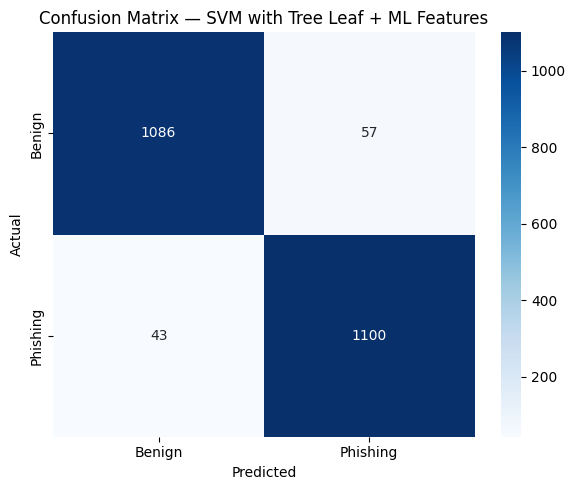

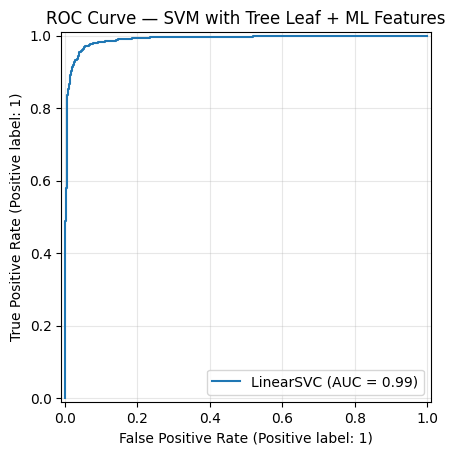

In [111]:
# =========================
# Confusion Matrix & ROC Curve
# =========================
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Benign", "Phishing"],
            yticklabels=["Benign", "Phishing"])
plt.title("Confusion Matrix — SVM with Tree Leaf + ML Features")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout(); plt.show()

RocCurveDisplay.from_estimator(svm_model, X_test, y_test)
plt.title("ROC Curve — SVM with Tree Leaf + ML Features")
plt.grid(alpha=0.3)
plt.show()


# Compare with Researcher Model


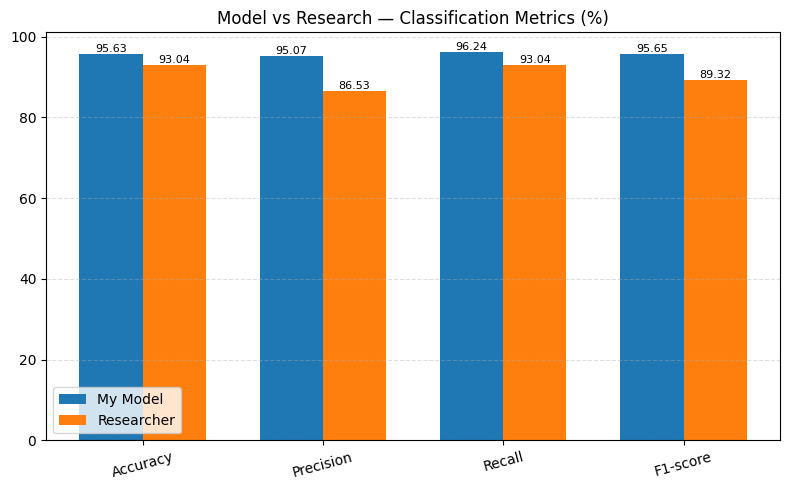

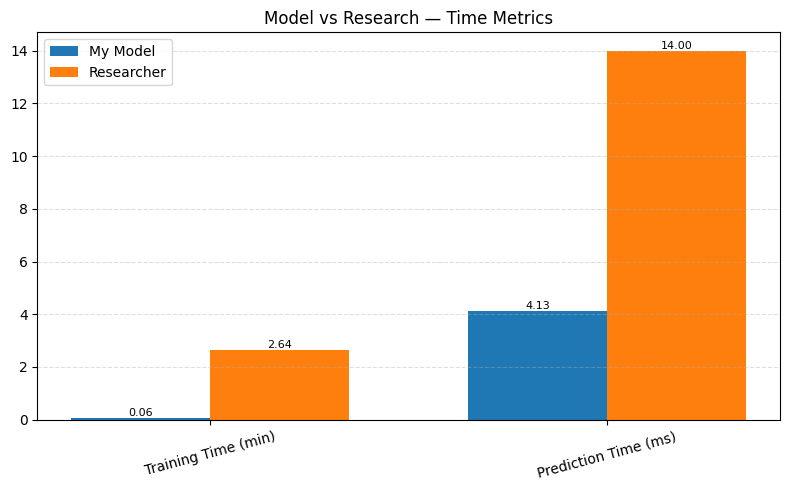

In [112]:
import matplotlib.pyplot as plt
import numpy as np

# =========================
# Your model's metrics (from calculation)
# =========================
my_metrics = {
    "Accuracy": 95.63,             # %
    "Precision": 95.07,            # %
    "Recall": 96.24,               # %
    "F1-score": 95.65,             # %
    "Training Time (min)": 0.063,  # minutes
    "Prediction Time (ms)": 4.13   # milliseconds
}

# =========================
# Researcher's metrics (manual entry)
# =========================
researcher_metrics = {
    "Accuracy": 93.04,       # %
    "Precision": 86.53,      # %
    "Recall": 93.04,         # %
    "F1-score": 89.32,       # %
    "Training Time (min)": 2.64,
    "Prediction Time (ms)": 14
}

# =========================
# Grouped bar chart function
# =========================
def grouped_bar_chart(keys, my_dict, ref_dict, title):
    x = np.arange(len(keys))
    width = 0.35

    my_vals  = [my_dict[k] for k in keys]
    ref_vals = [ref_dict[k] for k in keys]

    fig, ax = plt.subplots(figsize=(8, 5))
    bars1 = ax.bar(x - width/2, my_vals, width, label="My Model")
    bars2 = ax.bar(x + width/2, ref_vals, width, label="Researcher")

    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(keys, rotation=15)
    ax.legend()
    ax.grid(axis="y", linestyle="--", alpha=0.4)

    # Add value labels on top of bars
    for bars in (bars1, bars2):
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, height,
                    f"{height:.2f}", ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()

# =========================
# Plot charts
# =========================
percent_keys = ["Accuracy", "Precision", "Recall", "F1-score"]
time_keys    = ["Training Time (min)", "Prediction Time (ms)"]

grouped_bar_chart(percent_keys, my_metrics, researcher_metrics,
                  "Model vs Research — Classification Metrics (%)")
grouped_bar_chart(time_keys, my_metrics, researcher_metrics,
                  "Model vs Research — Time Metrics")
